# Predicting Popularity in Book Genres

## Data Science Tutorial

### Aminah Yizar

<img src='https://www.nytimes.com/vi-assets/static-assets/NYT-BestSeller-1200x675-699eb842421d5076f318fe0df3d903a5.png'>
     
-------------------------------------------------------------------------------------------------------------------------------

In the content below, you will learn about the Data Science pipeline and how to discover new information using this pipeline. While the Data Science pipeline can be applied to an infinite number of subjects, for the purposes of this tutorial, we will use Data Science to explore the possiblity of predicting popular book genres over time, using the New York Times BestSellers List.

#### Why Do We Care?

Why would we need to predict popular book genres, other than pure curiosity? Well, imagine working at some sort of publishing company, and being in charge of which books to accept for publishing. Speaking from a purely monetary perspective, you would want to pick books that are likely to be bought, i.e. popular/bestselling genres.

In [4]:
import requests as req
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from datetime import timedelta
import matplotlib.pyplot as plt
import pickle
from io import BytesIO
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [5]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 8)

## Data Scraping

-------------------------------------------------------------------------------------------------------------------------------

Before we can do anything, we need to scrape the data from the New York Times website. Luckily, the url is straightforward, and can be easily accessed with the correct date. To find these dates, we will use the string for the NYT's first online bestseller list page, '2008/06/08/', and use pandas' to_datetime function to turn the string into a datetime object. Then, incrementing by seven days through each iteration of the loop, we obtain all of the dates of the NYT's Bestseller List online to date.

In [2]:
date = pd.to_datetime("2008/06/08/")
dates = []

# creates the list of dates from 2008/06/08 to 2021/05/02
while date.strftime("%Y/%m/%d/") != '2021/05/09/':
    str = date.strftime("%Y/%m/%d/")
    date = date + timedelta(days=7)
    
    dates.append(str)

### Control

Unfortunately, accessing the New York Times page via url does not always work. Sometimes there is trouble finding the page, even though the correct url is used. In these cases, the page will redirect to the most current Bestseller's list. So, we need a table with those current values to compare to our other scraped data, in order to be sure that we do not have the wrong data for the date.

In [64]:
# use print(soup.prettify()) to display the html taken from the webpage
# from there, you will be able to use ctrl+f to find the key words you are looking for

r = req.get("https://www.nytimes.com/books/best-sellers/")
fp = r.text
soup = BeautifulSoup(fp, 'html.parser')

In [4]:
# finds the urls for the full lists of each section

categories = soup.find_all('option', value=lambda v: v and v.startswith("/books/best-sellers/"))
cat_titles = pd.Series([category.text for category in categories]).unique().tolist()
cat_urls = pd.Series(["https://www.nytimes.com" + category['value'] for category in categories]).unique().tolist()

In [5]:
# data from the page that broken urls redirect to

control = pd.DataFrame(data=np.nan, index=np.arange(1,16), columns=cat_titles)

In [6]:
for idx, url in enumerate(cat_urls):
    r = req.get(url)
    fp = r.text
    soup = BeautifulSoup(fp, 'html.parser')
    
    # finds all titles on the list, as well as their authors and rank    
    titles = [title.text for title in soup.find_all('h3', attrs={'itemprop':'name'})]
    authors = [author.text for author in soup.find_all('p', attrs={'itemprop':'author'})]
    time_on_list = [time.text for time in soup.find_all('p', attrs={'class':'css-1o26r9v'})]
    
    # formats the scraped information to fit easily into a DataFrame: the semicolons are separators in the string
    for i in np.arange(0, len(titles)):
        control[cat_titles[idx]][i + 1] = titles[i] + ";" + authors[i] + ";" + (time_on_list[i] if time_on_list!=[] else "")

<ipython-input-6-d1657a4ca0ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control[cat_titles[idx]][i + 1] = titles[i] + ";" + authors[i] + ";" + (time_on_list[i] if time_on_list!=[] else "")
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
control.head()

,Combined Print & E-Book Fiction,Hardcover Fiction,Paperback Trade Fiction,Combined Print & E-Book Nonfiction,...,Graphic Books and Manga,Mass Market,Middle Grade Paperback,Young Adult Paperback
1,21ST BIRTHDAY;by James Patterson and Maxine Pa...,THE LAST THING HE TOLD ME;by Laura Dave;New th...,WHERE THE CRAWDADS SING;by Delia Owens;6 weeks...,KILLING THE MOB;by Bill O'Reilly and Martin Du...,...,MOTHERING HEIGHTS;by Dav Pilkey;,A WALK ALONG THE BEACH;by Debbie Macomber;,THE ONE AND ONLY IVAN;by Katherine Applegate. ...,THEY BOTH DIE AT THE END;by Adam Silvera;
2,THE LAST THING HE TOLD ME;by Laura Dave;New th...,21ST BIRTHDAY;by James Patterson and Maxine Pa...,THE SILENT PATIENT;by Alex Michaelides;New thi...,THE PREMONITION;by Michael Lewis;New this week,...,CAT KID COMIC CLUB;by Dav Pilkey;,THE WEDDING DRESS;by Danielle Steel;,A LONG WALK TO WATER;by Linda Sue Park;,WE WERE LIARS;by E. Lockhart;
3,PROJECT HAIL MARY;by Andy Weir;New this week,SOOLEY;by John Grisham;2 weeks on the list,THE SONG OF ACHILLES;by Madeline Miller;29 wee...,WHAT HAPPENED TO YOU?;by Bruce D. Perry and Op...,...,GRIME AND PUNISHMENT;by Dav Pilkey;,UNDER CURRENTS;by Nora Roberts;,RESTART;by Gordon Korman;,SIX OF CROWS;by Leigh Bardugo;
4,SOOLEY;by John Grisham;2 weeks on the list,PROJECT HAIL MARY;by Andy Weir;New this week,THE WOMAN WITH THE BLUE STAR;by Pam Jenoff;New...,THE BOMBER MAFIA;by Malcolm Gladwell;2 weeks o...,...,FGTEEV SAVES THE WORLD!;by FGTeeV. Illustrated...,THE COUNTRY GUESTHOUSE;by Robyn Carr;,WISH;by Barbara O'Connor;,A GOOD GIRL'S GUIDE TO MURDER;by Holly Jackson;
5,WHERE THE CRAWDADS SING;by Delia Owens;129 wee...,THE HILL WE CLIMB;by Amanda Gorman;6 weeks on ...,LATER;by Stephen King;10 weeks on the list,FINDING THE MOTHER TREE;by Suzanne Simard;New ...,...,"MY HERO ACADEMIA, VOL. 27;by Kohei Horikoshi;",THE VISCOUNT WHO LOVED ME;by Julia Quinn;,OUT OF MY MIND;by Sharon M. Draper;,CROOKED KINGDOM;by Leigh Bardugo;


-------------------------------------------------------------------------------------------------------------------------------

Then, we use the method defined below, and a loop to generate a data table for each week on the online Bestseller's list.

This is the code used to generate the NYT data tables. I would not recommend running the blocks below, as it takes a very long time to compute the data for all dates on the list (20 dates => ~10 min).

However, if you want to test new_df for yourself with a random date or two, feel free to! Any date from the dates list in the first block above will create a valid url for new_df to use. If the data is not returned correctly, try navigating to the url manually and then running the block again.

In [8]:
# a general function that scrapes the data from any week on the NYT Bestsellers list into a DataFrame
def new_df (s):
    # gets the html from the main page
    r = req.get("https://www.nytimes.com/books/best-sellers/" + s)
    fp = r.text
    soup = BeautifulSoup(fp, 'html.parser')
    
    # gets all urls for each individual sublist
    categories = soup.find_all('option', value=lambda v: v and v.startswith("/books/best-sellers/"))
    cat_titles = pd.Series([category.text for category in categories]).unique().tolist()
    cat_urls = pd.Series(["https://www.nytimes.com" + category['value'] for category in categories]).unique().tolist()
    
    # creates an empty DataFrame for the data in each sublist
    df = pd.DataFrame(data=np.nan, index=np.arange(1,16), columns=cat_titles)
    
    # retrieves the books from each sublist and enters it into the DataFrame
    for idx, url in enumerate(cat_urls):
        r = req.get(url)
        fp = r.text
        soup = BeautifulSoup(fp, 'html.parser')
        
        # finds all titles on the list, as well as their authors and rank   
        titles = [title.text for title in soup.find_all('h3', attrs={'itemprop':'name'})]
        authors = [author.text for author in soup.find_all('p', attrs={'itemprop':'author'})]
        time_on_list = [time.text for time in soup.find_all('p', attrs={'class':'css-1o26r9v'})]
        
        # formats the information into a string
        info = []
        for i in np.arange(0, len(titles)):
            line = titles[i] + ";" + authors[i] + ";"
        
            if len(time_on_list) > i:
                line = line + time_on_list[i]
        
            info.append(line)
        
        # tests to make sure the data is not from a redirected page
        # if it is from a redirected page, the data is deleted
        for c in control.columns.values:
            if len(control[c]) == len(info):
                test = (control[c] == info).unique().tolist()
            if (len(test) == 1 and test[0]):
                info = np.empty(15)
                info[:] = np.nan
        
        # adds the data to the DataFrame
        df[cat_titles[idx]] = pd.Series(data=info, index=np.arange(1,len(info) + 1))
    return df

Example Output for the week of November 2nd, 2018

In [13]:
new_df(dates[534])

,Combined Print & E-Book Fiction,Hardcover Fiction,Paperback Trade Fiction,Combined Print & E-Book Nonfiction,...,Audio Nonfiction,Business,Science,Sports and Fitness
1,CRAZY RICH ASIANS;by Kevin Kwan;10 weeks on th...,TEXAS RANGER;by James Patterson and Andrew Bou...,CRAZY RICH ASIANS;by Kevin Kwan;17 weeks on th...,UNHINGED;by Omarosa Manigault Newman;New this ...,...,EDUCATED;by Tara Westover;,BAD BLOOD;by John Carreyrou;,SAPIENS;by Yuval Noah Harari;,FLY GIRLS;by Keith O'Brien;
2,TEXAS RANGER;by James Patterson and Andrew Bou...,THE PRESIDENT IS MISSING;by James Patterson an...,CHINA RICH GIRLFRIEND;by Kevin Kwan;4 weeks on...,THE RUSSIA HOAX;by Gregg Jarrett;4 weeks on th...,...,BORN A CRIME;by Trevor Noah;,DOPESICK;by Beth Macy;,DOPESICK;by Beth Macy;,SHOE DOG;by Phil Knight;
...,...,...,...,...,...,...,...,...,...
14,LESS;by Andrew Sean Greer;7 weeks on the list,CHERRY;by Nico Walker;New this week,PACHINKO;by Min Jin Lee;24 weeks on the list,KILLERS OF THE FLOWER MOON;by David Grann;61 w...,...,KITCHEN CONFIDENTIAL;by Anthony Bourdain;,NaN,NaN,NaN
15,RICHER THAN SIN;by Meghan March;New this week,THE PERFECT COUPLE;by Elin Hilderbrand;9 weeks...,THE ROOSTER BAR;by John Grisham;9 weeks on the...,KITCHEN CONFIDENTIAL;by Anthony Bourdain;12 we...,...,ASTROPHYSICS FOR PEOPLE IN A HURRY;by Neil deG...,NaN,NaN,NaN


In [ ]:
# initialization for the loop below
count = 0
all_dfs = []
len(dates)

In [ ]:
# a loop meant to be manually rerun until all of the data is scraped
# one iteration of this block takes about 10 minutes
for i in np.arange(count, count + 20):
    all_dfs.append(new_df(dates[i]))

count += 20
print(count)

Because the totality of the data takes so long to generate, we need to store the data somewhere. Using pandas.DataFrame.to_csv(file) saves a DataFrame to a csv file locally, so we will do that for now.

In [ ]:
# after the loop above is run once, run this loop to add the new DataFrames to your local files
for i in np.arange(count-20, count):
    df = all_dfs[i]
    file_name='NYT_data/'+ '{}'.format(i) + '.csv'
    df.to_csv(file_name)

Then, we need to find the genres for each book. The New York Times list doesn't have data for this, but GoodReads does! So, we will scrape the tags for each book from GoodReads. Unfortunately, the GoodReads API was discontinued in December 2020, so I didn't have direct access to each book's id, and therefore had to use a more roundabout method. This is also very computationally expensive, so again if you want to test this code, only use a few books. Do not run a large loop unless you are prepared to wait a while (500 => ~30 min).

In [14]:
# a general function that finds the goodreads tags for a book
def get_tags(book_and_author):
    # gets the html from the google search of the book
    r = req.get("https://www.google.com/search?q=goodreads " + book_and_author)
    fp = r.text
    soup = BeautifulSoup(fp, 'html.parser')

    # finds all links on the first page of the google search that lead to a goodreads book entry
    search_str = "/url?q=https://www.goodreads.com/book/show/"
    links = [link['href'] for link in soup.find_all('a', href=True)]
    good_link = [link if link.find(search_str) != -1 else np.nan for link in links]
    
    if pd.Series(good_link).dropna().tolist() != []:
        good_link = pd.Series(good_link).dropna().tolist()
        
        # if the title is in the goodreads link, we know that is the correct link
        good_link = [link for link in good_link if book_and_author[0:book_and_author.index(' ')].lower() in link.lower()]
        
        # if the correct link is found, we use BeautifulSoup again to parse the tags from that page's html
        if good_link != []:
            good_link = good_link[0]
            good_link = good_link[good_link.index('https'):]

            r = req.get(good_link)
            fp = r.text
            soup = BeautifulSoup(fp, 'html.parser')

            tags = [tag.text for tag in soup.find_all('a', class_='actionLinkLite bookPageGenreLink')]
            tags = pd.Series(tags).unique().tolist()
    
            return tags
    
    # if a link is not found, an empty list of is returned (no tags could be found for that book)
    return []

In [ ]:
# creates a list of all titles we found while scraping the New York Times list
# title format: "title;author;rank" => "title author"
titles = []
for i, df in enumerate(all_dfs):
    for col in df.columns.values:
        for idx in df.index.values:
            book = df[col][idx]
            
            if book != 'no entry':
                title = book[0:book.index(';')]
                author = book[book.index(';') + 1:book.rindex(';')]
                titles.append(title + ' ' + author)

Example Output for the book 'Crazy Rich Asians' by Kevin Kwan

In [16]:
get_tags('CRAZY RICH ASIANS by Kevin Kwan')

['Fiction',
 'Romance',
 'Contemporary',
 'Womens Fiction',
 'Chick Lit',
 'Audiobook',
 'Adult',
 'Humor',
 'Adult Fiction',
 'Cultural',
 'Asia',
 'Realistic Fiction']

In [65]:
# initialization for the loop below
count = 0
t = []
for title in titles:
    t.append(title)

In [441]:
# a loop meant to be manually rerun until all of the data is scraped
# one iteration of this block takes about 30 minutes
for i in np.arange(count, count + 500):
    tags[t[i]] = get_tags(t[i])
count += 500

<ipython-input-199-2c93875327e9>:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tags = pd.Series(tags).unique().tolist()


Now we need to save the tags variable locally. Because the tags variable is not a DataFrame, we cannot use pd.DataFrame.to_csv(file), however we can use something called pickle in python instead. Using pickle we can save the tags variable as 'tags.pickle' locally, and we can read it in later to use, also via pickle.

In [443]:
# saves the tags to a local file
# it is reccommended to run this after every iteration of the above loop in case of kernel death
pickle_out = open("tags.pickle", "wb")
pickle.dump(tags, pickle_out)
pickle_out.close()

#### Resources

New York Times Bestseller Datasets and Tag Data: https://github.com/ayizar/NewYorkTimesBestsellers

Python datetime Documentation: https://docs.python.org/3/library/datetime.html

Beautiful Soup Documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

Python pickle Documentation: https://docs.python.org/3/library/pickle.html

Pandas Documentation: https://pandas.pydata.org/docs/

StackOverflow: Chances are, if you're starting out and have a question, it's been asked before!

-------------------------------------------------------------------------------------------------------------------------------

## Data Wrangling

If you studied the methods above, you now have an idea of how data scraping works. Now we need to wrangle the data. Read in the New York Times DataFrames through pd.read_csv(file), and replace the NaN (nonexistant) values with some stand-in. For our purposes, this stand-in will be the string 'no entry'.

In [6]:
# can be used as a starting point if not scraping the data yourself
# creates the list of dates again

date = pd.to_datetime("2008/06/08/")
dates = []

while date.strftime("%Y/%m/%d/") != '2021/05/09/':
    str = date.strftime("%Y/%m/%d/")
    date = date + timedelta(days=7)
    
    dates.append(str)

In [7]:
all_dfs = []

for i in np.arange(0, len(dates)):
    # reads in all of the DataFrames from my github repository
    df = pd.read_csv('https://raw.githubusercontent.com/ayizar/NewYorkTimesBestsellers/main/' + '{}'.format(i) + '.csv')
    df = df.set_index('Unnamed: 0')
    
    for col in df.columns.values:
        if len(df[col].dropna().tolist()) == 0:
            df.pop(col)
        
    
    all_dfs.append(df)

In [8]:
# fills the nan values in all of the DataFrames with 'no entry'
for i, df in enumerate(all_dfs):
    all_dfs[i] = all_dfs[i].fillna('no entry')

Then, we create two essential dictionaries. The keys for both are the title and author, as read in from the DataFrames.

example key: 'CRAZY RICH ASIANS by Kevin Kwan'

The titles dictionary contains all of the dates that this book was on the Bestseller's list, as well as its rank on the list for each date.

The tags dictionary simply contains all of the GoodReads tags for each book.

In [9]:
titles = {} # "title by author":[[dates], [rankings]] where len(dates) or len(rankings) is num weeks on board

In [10]:
tags = {} # "title by author":[goodreads tags]

In [11]:
# creates a dictionary of book titles and their respective dates and rankings on the NYT list
for i, df in enumerate(all_dfs):
    for col in df.columns.values:
        for idx in df.index.values:
            book = df[col][idx]
            
            # skips if there is no entry
            if book != 'no entry':
                title = book[0:book.index(';')]
                author = book[book.index(';') + 1:book.rindex(';')]
                rank = idx
                week = i
            
                # 'title;author;rank' => titles[title author] = [[dates], [ranks]]
                if (title + ' ' + author) in titles:
                    titles[title + ' ' + author][0].append(week)
                    titles[title + ' ' + author][1].append(rank)
                else:
                    titles[title + ' ' + author] = [[week],[rank]]

In [12]:
# reads in the tags dictionary from my github repository
link = 'https://raw.githubusercontent.com/ayizar/NewYorkTimesBestsellers/main/tags.pickle'
file = BytesIO(req.get(link).content)
tags = pickle.load(file)

We want to try and find trends in the Bestseller's list over time, so we should organize our data to reflect this.

The dates_by_year list separates the dates variable into smaller lists, containing the indices that match each week in the dates list for the individual year.

In [13]:
year = 2008
dates_by_year = []
i = 0

# appends the list of weeks from 2008-2020 to the list dates_by_year
for idx, date in enumerate(dates):
    if int(pd.to_datetime(date).strftime("%Y")) != year:
        dates_by_year.append(np.arange(i, idx).tolist())
        year += 1
        i = idx

# appends the list of weeks from 2021 to the list dates_by_year
dates_by_year.append(np.arange(i, idx + 1).tolist())

In [71]:
# shows which date indices are in which years
for i,week in enumerate(dates_by_year):
    print(("{}").format(2008+i))
    print(dates_by_year[i])
    print()

2008
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

2009
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]

2010
[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]

2011
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185]

2012
[186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 2

It's all right to play with data and shape it into different forms, especially if you think you may need them later! It will help you to understand your data better, which is essential. If you don't end up needing it, you can always delete the variable.

The tag_occurrences variable was part of this process, and ended up being useful further down. The books_by_year variable and tag_ranks variables were useful as well, even if they weren't used for much.

In [14]:
# creates a dictionary where the key is the genre and the value is the number of NYT Bestselling books it applies to
tag_occurrences = {}
for book in tags:
    t = tags[book]
    for tag in t:
        if tag in tag_occurrences:
            tag_occurrences[tag] += 1
        else:
            tag_occurrences[tag] = 1

In [81]:
tag_occurrences['Horror']

628

In [15]:
# creates a triple list of titles per week per year
books_by_year = []
for i, year in enumerate(dates_by_year):
    books_by_year.append([])
    for date in year:
        # books_in_date is a list of titles on the NYT list in a given week (date)
        books_in_date = []
        for book in titles:
            if date in titles[book][0]:
                books_in_date.append(book)
        # books_by_year[i] is the list of books on the NYT list for each week in year i
        books_by_year[i].append(books_in_date)

In [84]:
books_by_year[0][0][0:5] # books from the first week in 2008 (the first year)

['ODD HOURS by Dean R. Koontz',
 'THE HOST by Stephenie Meyer',
 "LOVE THE ONE YOU'RE WITH by Emily Giffin",
 'THE FRONT by Patricia Cornwell',
 'SNUFF by Chuck Palahniuk']

In [16]:
index_max_len = 0

for i, year in enumerate(dates_by_year):
    if len(year) > len(dates_by_year[index_max_len]):
        index_max_len = i

# initializes a DataFrame to store arrays of genre-rank tuples for each week in each year on the NYT list
tag_ranks = pd.DataFrame(data=[], index=np.arange(0, len(dates_by_year[index_max_len])), columns=np.arange(0,len(dates_by_year)))

In [17]:
years = tag_ranks.columns.values
weeks = tag_ranks.index.values

# adds genre-rank tuples to tag_ranks DataFrame
for year in years:
    for week, date in enumerate(dates_by_year[year]):
        # a dictionary of format dict_tag_ranks[tag] = [sum_ranks, tag_occurrences]
        dict_tag_ranks = {}
        for book in books_by_year[year][week]:
            t = tags[book]
            rank = titles[book][1][titles[book][0].index(date)]

            for tag in t:
                if tag in dict_tag_ranks:
                    dict_tag_ranks[tag][0] += rank
                    dict_tag_ranks[tag][1] += 1
                else:
                    dict_tag_ranks[tag] = [rank, 1]
        # averages the tag ranks
        for tag in dict_tag_ranks:
            dict_tag_ranks[tag] = dict_tag_ranks[tag][0]/dict_tag_ranks[tag][1]
        
        # adds a tuple of the tag and the average rank to the DataFrame
        tag_ranks[year][week] = list(dict_tag_ranks.items())

In [18]:
tag_ranks.set_axis(np.arange(2008,2022), axis=1, inplace=True)
tag_ranks

,2008,2009,2010,2011,...,2018,2019,2020,2021
0,"[(Horror, 5.0), (Fiction, 6.626865671641791), ...","[(Young Adult, 5.230769230769231), (Science Fi...","[(Fiction, 6.467391304347826), (Animals, 5.8),...","[(Fiction, 6.56043956043956), (Animals, 6.0), ...",...,"[(Fiction, 7.018518518518518), (Humor, 6.5), (...","[(Nonfiction, 7.844827586206897), (Crime, 8.72...","[(Fiction, 6.8584905660377355), (Humor, 6.75),...","[(Fiction, 7.111111111111111), (Humor, 7.125),..."
1,"[(Horror, 6.6), (Fiction, 6.666666666666667), ...","[(Young Adult, 5.206896551724138), (Science Fi...","[(Fiction, 6.406593406593407), (Animals, 7.5),...","[(Fiction, 6.466666666666667), (Animals, 6.5),...",...,"[(Fiction, 6.859649122807017), (Humor, 5.53333...","[(Nonfiction, 7.677966101694915), (Crime, 7.8)...","[(Fiction, 6.91743119266055), (Humor, 6.125), ...","[(Fiction, 7.216494845360825), (Humor, 7.05882..."
...,...,...,...,...,...,...,...,...,...
51,NaN,"[(Fiction, 6.516483516483516), (Animals, 6.2),...","[(Fiction, 6.534090909090909), (Animals, 7.0),...","[(Fiction, 6.65979381443299), (Animals, 6.5833...",...,"[(Nonfiction, 7.238095238095238), (Crime, 8.25...","[(Fiction, 7.284403669724771), (Humor, 6.84), ...","[(Fiction, 6.926315789473684), (Humor, 6.6), (...",NaN
52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN


#### Resources

Pandas API Reference: https://pandas.pydata.org/docs/reference/index.html#api

Pandas DataFrame Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

Pandas Series Reference: https://pandas.pydata.org/docs/reference/api/pandas.Series.html#pandas.Series

## Data Visualisation

-------------------------------------------------------------------------------------------------------------------------------

After playing with the data for a little bit, we want to start graphing the data, so that it is easier to interpret and find patterns.

In [19]:
tag_list = []
# creates a double list of tags in each year, using tag_ranks
for i, year in enumerate(np.arange(2008,2022)):
    tag_list.append([])
    for week in tag_ranks[year].values:
        if week == week:
            for tag_rank in week:
                tag_list[i].append(tag_rank[0])
    tag_list[i] = pd.Series(tag_list[i]).unique().tolist()

In [85]:
tag_list[0][0:5] # genres on the NYT list in 2008

['Horror', 'Fiction', 'Thriller', 'Suspense', 'Mystery']

In [20]:
genre_rankings = {}
# creates a dictionary of average genre rankings per year, using tag_rank and tag_list
for i, year in enumerate(np.arange(2008,2022)):
    genre_rankings[year] = pd.DataFrame(data=np.nan, index=np.arange(0,len(dates_by_year[i])), columns=tag_list[i])
    for column in genre_rankings[year].columns.values:
        for idx in genre_rankings[year].index.values:
            for tag_rank in tag_ranks[year][idx]:
                if tag_rank[0] == column:
                    genre_rankings[year][column][idx] = tag_rank[1]

In [73]:
genre_rankings[2008].head()

,Horror,Fiction,Thriller,Suspense,...,Germany,Geography,Cartography,Maps
0,5.00,6.626866,8.000000,7.000000,...,NaN,NaN,NaN,NaN
1,6.60,6.666667,8.909091,8.600000,...,NaN,NaN,NaN,NaN
2,9.00,6.750000,8.750000,8.285714,...,NaN,NaN,NaN,NaN
3,11.50,6.550725,8.083333,6.285714,...,NaN,NaN,NaN,NaN
4,11.75,6.528571,6.545455,8.285714,...,NaN,NaN,NaN,NaN


In [21]:
# a function that averages all of the numbers in a list, Series, dictionary, etc, ignoring nan entries
def avg(col):
    count = 0
    sum = 0
    for entry in col:
        # ignores nan values
        if entry == entry:
            count += 1
            sum += entry
    
    return sum/count

Since we have a lot of data, it's a good idea to take a subset of importance to operate on, instead of using all of the data. In this case, we will take the top 25% popular genres from our data. This is what we will call the 'most popular' genres.

But how do we define 'popular'?

Well, the most simple definition would be the genre with the highest average ranking. However, this does not take into account prolonged interest in consumers, or how long the genre remains on the NYT Bestsellers List. 

For example, what if a book with a certain genre is number 1 on the list for a week, but then drops off entirely? Counter to that, what if a book has a middling or low rank but has been on the list for over a year?

Quantifying the definition of 'popular' is subjective, and the reader of this article may have a definition counter to mine. However, I believe the best way to quantify the popularity of a genre is to weight its average ranking, with the weight favoring genres that remain on the list for long periods. This is implemented below.

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


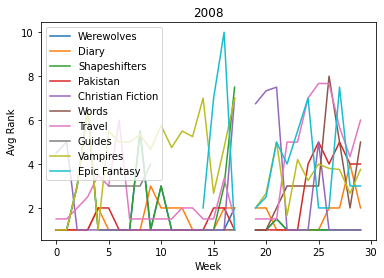

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


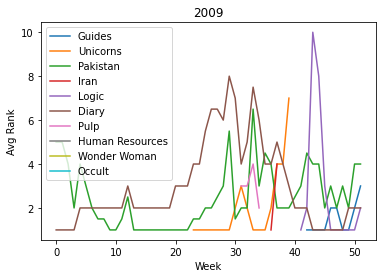

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


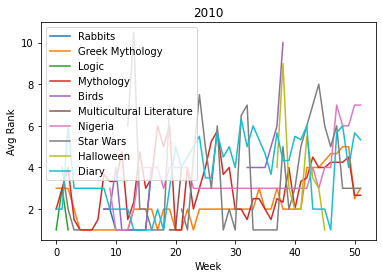

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28459 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 28459 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0, flags=flags)


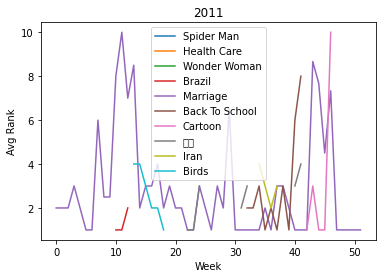

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


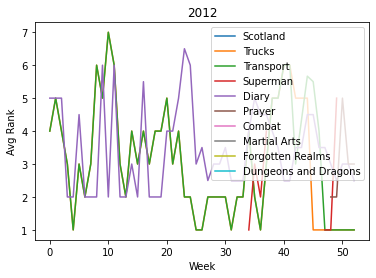

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


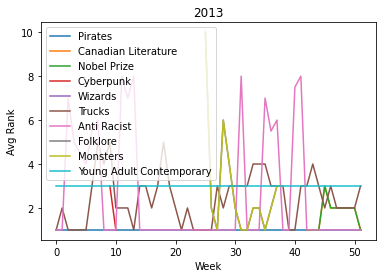

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


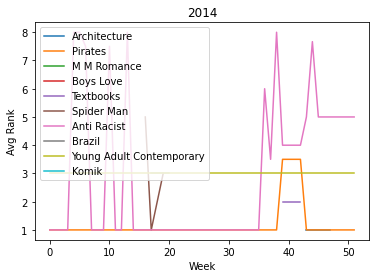

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


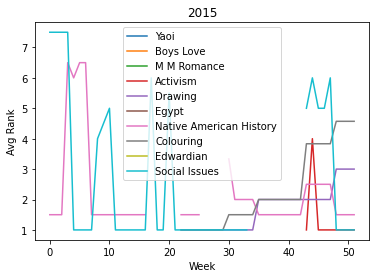

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


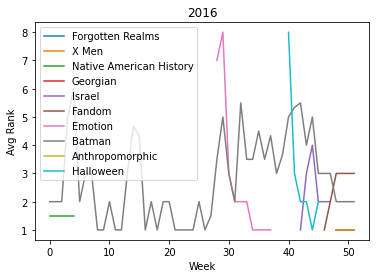

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


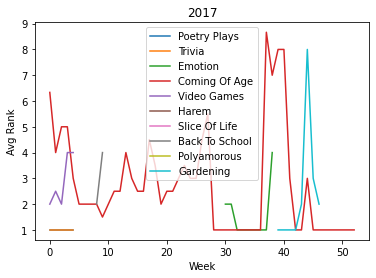

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


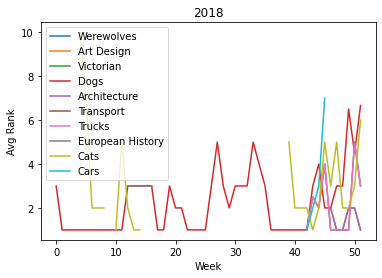

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


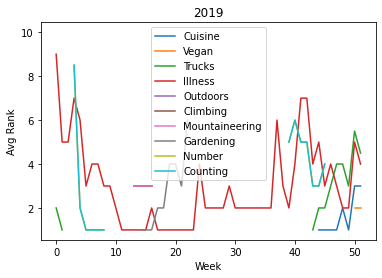

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


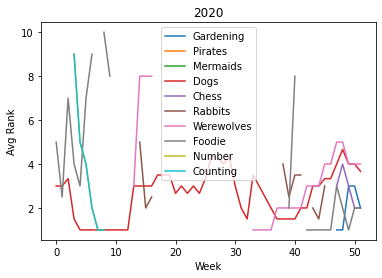

<ipython-input-22-e4b370e93cab>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)


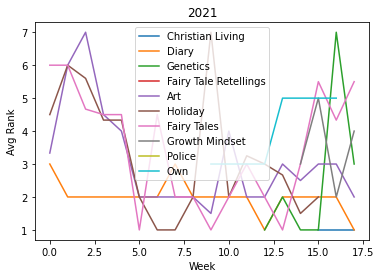

In [22]:
top_25_percent = int(len(tag_occurrences) * .25)
top_tags_per_year = pd.DataFrame(data=0.0, columns=np.arange(2008, 2022), index=np.arange(1,top_25_percent + 1))

# finds the top 25 percent of tags for each year based on weighted average ranking
for year in np.arange(2008,2022):
    # creates the average rankings for each genre in the current year
    yearly_rank_avg=pd.Series(index=genre_rankings[year].columns.values)
    for column in genre_rankings[year]:
        yearly_rank_avg[column] = avg(genre_rankings[year][column])
    yearly_rank_avg = yearly_rank_avg.sort_values()
    
    # creates the weighted average rankings for each genre in the current year
    weighted_yearly_rank_avg = yearly_rank_avg.copy()
    for column in genre_rankings[year]:
        # weighted average = average * (# weeks absent)/(# weeks in the year)
        weighted_yearly_rank_avg[column] *= len(genre_rankings[year][column][genre_rankings[year][column]==0])/len(genre_rankings[year][column])
    weighted_yearly_rank_avg = weighted_yearly_rank_avg.sort_values()
    
    # enters the top 25 % of genres into the top_tags_per_year DataFrame
    top_tags_per_year[year] = weighted_yearly_rank_avg[0:top_25_percent].index.values
    
    # the actual ranks of the top weighted genres
    rank_avg = yearly_rank_avg[weighted_yearly_rank_avg == 0]
    
    # plots the rankings over time for the top weighted genres
    cols = rank_avg[0:10].index.values
    for col in cols:
        plt.plot(genre_rankings[year][col], label=col)
    
    plt.xlabel('Week')
    plt.ylabel('Avg Rank')
    plt.title(year)
    plt.legend()
    plt.show()

Also, by plotting the top 10 genres for each year, using this method, we can see that each genre has very different trends across time, even over the course of one year. This implies that later, when attempting to predict patterns, the prediction will have to be reliant on both the genre and the week; the equation will probably not be very generalizeable.

In [23]:
top_tags_per_year

,2008,2009,2010,2011,...,2018,2019,2020,2021
1,Werewolves,Guides,Rabbits,Spider Man,...,Werewolves,Cuisine,Gardening,Christian Living
2,Theology,European Literature,Religion,Historical Romance,...,Mystery Thriller,Technology,Environment,World War II
...,...,...,...,...,...,...,...,...,...
184,Gardening,Victorian,Southern Africa,Womens Studies,...,Literary Fiction,Photography,Womens,Christian Non Fiction
185,Communication,Knitting,American Revolution,Gender Studies,...,Southern,Asia,American Revolution,Mermaids


We can also see, using these bar graphs of the top 25% of popular genres per year that even with the weights, higher ranked genres precede lower ranked genres in order of popularity. This is not strict, but it can be visually seen in a general sense.

The only graph where the lower weighted ranked genres have higher unweighted ranks is in 2021, which makes sense because we are still in that year, and certain titles/genres cannot have been on the list for as long as some others. So, those are likely newly released Bestsellers.

<ipython-input-24-8b0a3c6c2ae8>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_rankings = pd.Series(index=top_tags_per_year[year])


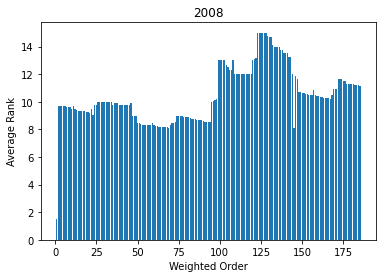

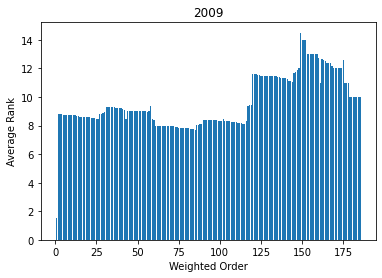

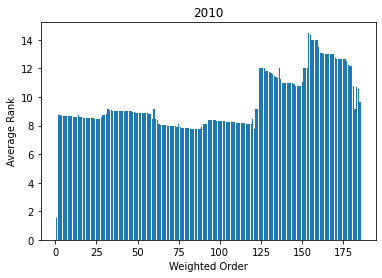

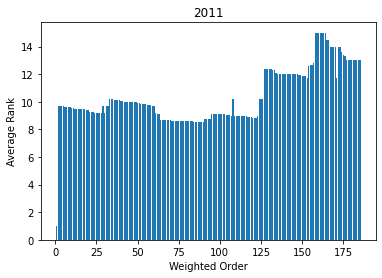

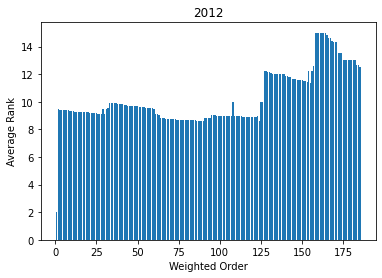

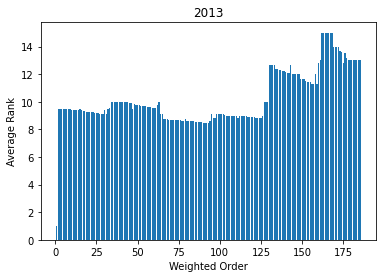

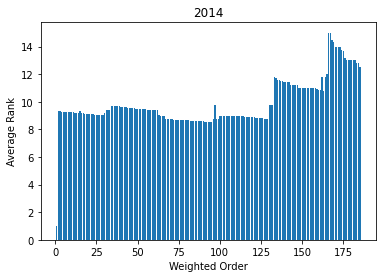

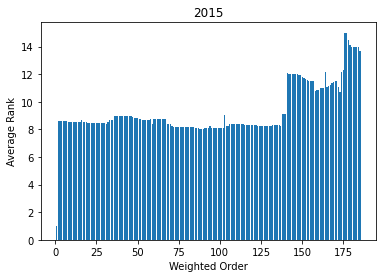

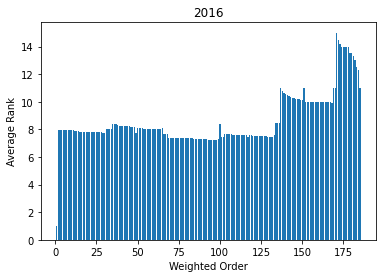

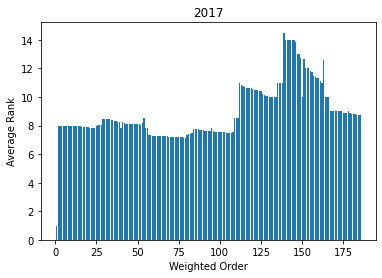

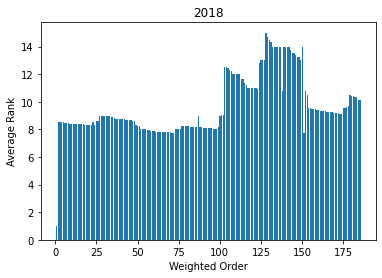

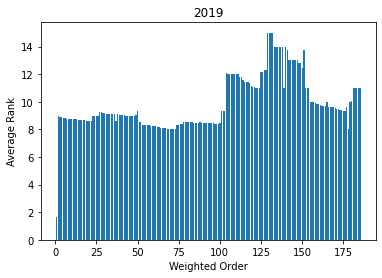

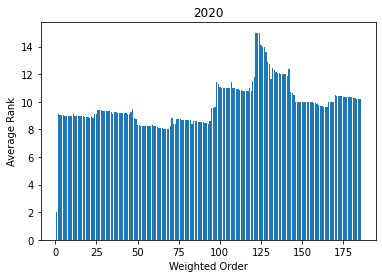

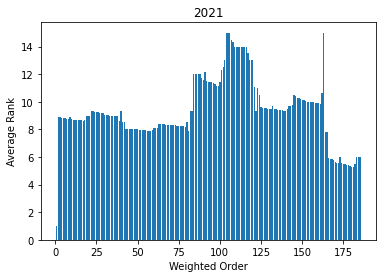

In [24]:
# produces the bar plots for the weighted order of genres vs their actual average rank
for year in top_tags_per_year.columns.values:
    avg_rankings = pd.Series(index=top_tags_per_year[year])
    for col in top_tags_per_year[year]:
        avg_rankings[col] = avg(genre_rankings[year][col])
        
    plt.bar(np.arange(1,top_25_percent+1).tolist(), avg_rankings.tolist())
    plt.xlabel('Weighted Order')
    plt.ylabel('Average Rank')
    plt.title(year)
    plt.show()

#### Resources

Matplotlib Pyplot Tutorial: https://matplotlib.org/stable/tutorials/introductory/pyplot.html

Matplotlib Plot Documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

Matplotlib Bar Plot Documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

## Machine Learning

-------------------------------------------------------------------------------------------------------------------------------

Now that we know enough about the data, we can begin to use Machine Learning to try predicting how the popular genres change over time. We will use the top 25% of popular tags that we found before to do so.

This way, we will be able to predict how a top popular genre in a single year operates in other years (though it is important to note there may be overlap, such as a genre present in most or all years).

We are going to try to fit a polynomial model using sklearn to the tag rankings over time. While we don't expect the results to be good based on the graphs above, it is good to know how off the estimates are, so that we know how much we need to course correct.

In [25]:
# a series of the top tags per year from all years

top_tags = pd.Series(top_tags_per_year.values.reshape(1, 2590)[0]).unique().tolist()

In [26]:
# a method that returns a list all average rankings of a genre for all weeks
def tag_across_time(tag):

    t_ranks = []
    
    # if the genre is not in a week, zeros are used instead of nan
    for year in np.arange(2008,2022):
        if tag in genre_rankings[year].columns.values:
            t_ranks += genre_rankings[year][tag].fillna(0).tolist()
        else:
            t_ranks += np.zeros(len(genre_rankings[year])).tolist()
    
    return t_ranks

In [27]:
# a method that creates and returns a model of sklearn's poly.fit
def rank_predict(train, test, d):
    ind = train.drop('rank', axis=1)
    dep = train['rank'].to_numpy().reshape(1,-1)
    predict= test.drop('rank', axis=1)
    
    poly = PolynomialFeatures(degree=d)
    dep_ = poly.fit_transform(dep)
    predict_ = poly.fit_transform(predict)

    model = Pipeline([('poly', PolynomialFeatures(degree=d)), ('linear', LinearRegression(fit_intercept=False))])
    
    # fit to an order-3 polynomial data
    model = model.fit(ind, dep)
    model.named_steps['linear'].coef_
    
    return model

In [28]:
tags_by_time = pd.DataFrame(data=0.0, columns=top_tags, index=np.arange(0,len(dates)))

In [29]:
# creates a DataFrame of all top 25% tags and their ranking for each week on the NYT list
for col in tags_by_time.columns.values:
    tags_by_time[col] = tag_across_time(col)
    
# sets nan instances to 20, a reasonable number that is not on the NYT rankings but hopefully won't skew the data too much
tags_by_time.replace(0.0,20.0,inplace=True)

In [30]:
tags_by_time

,Werewolves,Guides,Rabbits,Spider Man,...,Georgian,Beauty and The Beast,Edwardian,Gender Studies
0,1.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0
1,1.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...
672,10.0,20.0,20.0,20.0,...,20.0,3.0,20.0,20.0
673,9.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0


We will use 10-fold cross validation to test how accurate the model is, and print out the error for the model of each fold. Then we will know how much the model varies depending on the information it is given from the dataset. Since we know from the graphs above that each genre behaves very differently, we will try to model with an interaction between genre and week.

In [31]:
kf = KFold(n_splits=10, shuffle=False)

In [32]:
# creates a DataFrame that can be used with pandas.get_dummies()
tag_data=pd.DataFrame(data=np.nan, columns=['genre','week','rank'], index=np.arange(0,0))

for genre in tags_by_time.columns.values:
    g = pd.Series(data=genre, index=np.arange(0, len(tags_by_time[genre])))
    w = pd.Series(np.arange(0, len(tags_by_time[genre])))
    r = tags_by_time[genre]
    tag_data = tag_data.append(pd.DataFrame(data={'genre':g, 'week':w, 'rank':r}))

In [33]:
tag_data.head()

,genre,week,rank
0,Werewolves,0.0,1.0
1,Werewolves,1.0,1.0
2,Werewolves,2.0,3.0
3,Werewolves,3.0,6.5
4,Werewolves,4.0,1.0


In [34]:
tag_features = pd.get_dummies(data=tag_data.genre, drop_first=True, prefix='tag')
tag_features.head()

,tag_15th Century,tag_16th Century,tag_17th Century,tag_18th Century,...,tag_Zen,tag_Zimbabwe,tag_Zombies,tag_漫画
0,0,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,0,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,0,0,0,0,...,0,0,0,0


In [35]:
standard_features = tag_data[['week', 'rank']]
combined_features = pd.concat([standard_features, tag_features],axis=1)

# creates a table that can be used to find a model with interactions between week and genre
for genre in tag_features.columns.values:
    combined_features['week*' + genre[4:]] = combined_features[genre] * combined_features['week']
combined_features.head()

,week,rank,tag_15th Century,tag_16th Century,...,week*Zen,week*Zimbabwe,week*Zombies,week*漫画
0,0.0,1.0,0,0,...,0.0,0.0,0.0,0.0
1,1.0,1.0,0,0,...,0.0,0.0,0.0,0.0
2,2.0,3.0,0,0,...,0.0,0.0,0.0,0.0
3,3.0,6.5,0,0,...,0.0,0.0,0.0,0.0
4,4.0,1.0,0,0,...,0.0,0.0,0.0,0.0


In [ ]:
# hypothetically calculates a polynomial model for each k-fold and prints the mean squared error
for train_index, test_index in kf.split(combined_features):
    tag_train, tag_test = combined_features.iloc[train_index], combined_features.iloc[test_index]
    model = rank_predict(tag_train, tag_test, 5)
    
    err = mean_squared_error(true, model.predict(predict))
    
    print("Error: " + '{}'.format(err))

This sort of model would probably be ideal, but the data here is too large for my computer to handle efficiently.

What now?

Well, let's try a different approach and use not the top 25% of each year's tags, but the top 5 tags of all time.

In [36]:
top_tags_overall = pd.Series(data=0.0,index=top_tags)
top_tags_helper = pd.Series(data=0.0,index=top_tags)

# finds the top tags of all time from the tags in the top 25% of tags
for year in np.arange(2008,2022):
    for genre in genre_rankings[year].columns.values:
        if genre in top_tags:
            top_tags_overall[genre] += genre_rankings[year][genre].sum()
            top_tags_helper[genre] += len(genre_rankings[year][genre].dropna())

In [37]:
# the weighted rank for the top tags of all time
temp = top_tags_overall * (len(dates)-top_tags_helper)/(top_tags_helper*len(dates))

In [38]:
# the top weighted ranks will be equal to zero, so use these as the top tags of all time
top_tags_overall = top_tags_overall[temp==0]
top_tags_overall /= top_tags_helper
top_tags_overall=top_tags_overall.sort_values()

In [39]:
# takes the top 5 tags from the top tags of all time
top_5 = top_tags_overall[0:5]

In [40]:
top_5.index.values

array(['Science Fiction', 'World War II', 'Contemporary', 'War',
       'Mystery'], dtype=object)

In [88]:
# repeat the earlier steps to get the dummy variable table for 2008-2018
top_tag_data=pd.DataFrame(data=np.nan, columns=['genre','week','rank'], index=np.arange(0,0))
for genre in top_5.index.values:
    g = pd.Series(data=genre, index=np.arange(0, 551))
    w = pd.Series(np.arange(0, 551))
    r = tags_by_time[genre].iloc[0:551]
    top_tag_data = top_tag_data.append(pd.DataFrame(data={'genre':g, 'week':w, 'rank':r}))

In [89]:
top_tag_data

,genre,week,rank
0,Science Fiction,0.0,7.111111
1,Science Fiction,1.0,8.300000
...,...,...,...
549,Mystery,549.0,8.960000
550,Mystery,550.0,9.652174


In [90]:
top_tag_features = pd.get_dummies(data=top_tag_data.genre, drop_first=True, prefix='tag')
top_tag_features

,tag_Mystery,tag_Science Fiction,tag_War,tag_World War II
0,0,1,0,0
1,0,1,0,0
...,...,...,...,...
549,1,0,0,0
550,1,0,0,0


In [91]:
standard_features = top_tag_data[['week', 'rank']]
combined_features = pd.concat([standard_features, top_tag_features],axis=1)

for genre in top_tag_features.columns.values:
    combined_features['week*' + genre[4:]] = combined_features[genre] * combined_features['week']
combined_features

,week,rank,tag_Mystery,tag_Science Fiction,...,week*Mystery,week*Science Fiction,week*War,week*World War II
0,0.0,7.111111,0,1,...,0.0,0.0,0.0,0.0
1,1.0,8.300000,0,1,...,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
549,549.0,8.960000,1,0,...,549.0,0.0,0.0,0.0
550,550.0,9.652174,1,0,...,550.0,0.0,0.0,0.0


In [ ]:
# hypothetically calculates a polynomial model for each k-fold and prints the mean squared error
for train_index, test_index in kf.split(combined_features):
    tag_train, tag_test = combined_features.iloc[train_index], combined_features.iloc[test_index]
    model = rank_predict(tag_train, tag_test, 5)
    
    err = mean_squared_error(true, model.predict(predict))
    
    print("Error: " + '{}'.format(err))

This still is too much data for my computer. Let's not give up!

Instead of using a costly polynomial model, let's try using simple linear regression. This is not likely to give a very accurate result, but it will still give us some prediction to view.

In [93]:
best_err = 100

# calculates a linear model for each k-fold and prints the mean squared error
for train_index, test_index in kf.split(combined_features):
    tag_train, tag_test = combined_features.iloc[train_index], combined_features.iloc[test_index]
   
    ind = tag_train.drop('rank', axis=1)
    dep = tag_train['rank'].to_numpy()
    predict= tag_test.drop('rank', axis=1)
    true = tag_test['rank'].to_numpy()
    
    lm = linear_model.LinearRegression()
    lm.fit(ind, dep)
    err = mean_squared_error(true, lm.predict(predict))
    
    print("Error: " + '{}'.format(err))
    
    if best_err < err:
        best_err = err
        best_model = lm

Error: 4.7775464567146555
Error: 1.8891122524816388
Error: 4.769554435271239
Error: 13.520502770041826
Error: 0.9231692093095087
Error: 1.4718051876329847
Error: 2.272294943236106
Error: 10.311443932543341
Error: 0.6825943135726564
Error: 1.7369200428678988


In [94]:
# adds a prediction and residual column to combined_features
combined_features['prediction'] = lm.predict(combined_features.drop('rank', axis=1))
combined_features['residual'] = combined_features['rank'] - combined_features['prediction']

In [95]:
# the absolute value of the resulting residuals are never greater than 5
print(combined_features['residual'])

0      1.195939
1      2.383452
         ...   
549   -0.313488
550    0.375086
Name: residual, Length: 2755, dtype: float64


These residuals are actually not bad! However, this is data based on the years 2008-2018. Can the model predict well for 2019-2021?

In [96]:
# repeats the steps above for years 2019-2021
predict=pd.DataFrame(data=np.nan, columns=['genre','week','rank'], index=np.arange(552,552))
for genre in top_5.index.values:
    g = pd.Series(data=genre, index=np.arange(552, 674))
    w = pd.Series(np.arange(552, 674), index=np.arange(552, 674))
    r = tags_by_time[genre].iloc[552:674]
    
    predict = predict.append(pd.DataFrame(data={'genre':g, 'week':w, 'rank':r},index=np.arange(552, 674)))

In [97]:
predict_features = pd.get_dummies(data=predict.genre, drop_first=True, prefix='tag')
predict_features

,tag_Mystery,tag_Science Fiction,tag_War,tag_World War II
552,0,1,0,0
553,0,1,0,0
...,...,...,...,...
672,1,0,0,0
673,1,0,0,0


In [98]:
standard_features = predict[['week', 'rank']]
combined_features = pd.concat([standard_features, predict_features],axis=1)

for genre in top_tag_features.columns.values:
    combined_features['week*' + genre[4:]] = combined_features[genre] * combined_features['week']
combined_features

,week,rank,tag_Mystery,tag_Science Fiction,...,week*Mystery,week*Science Fiction,week*War,week*World War II
552,552.0,8.000000,0,1,...,0.0,552.0,0.0,0.0
553,553.0,8.000000,0,1,...,0.0,553.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
672,672.0,8.346154,1,0,...,672.0,0.0,0.0,0.0
673,673.0,8.409091,1,0,...,673.0,0.0,0.0,0.0


In [99]:
# instead of calculating a new model, use the one we just found to see if it is accurate
combined_features['prediction'] = lm.predict(combined_features.drop('rank', axis=1))
combined_features['residual'] = combined_features['rank'] - combined_features['prediction']

In [102]:
# the absolute value of the resulting residuals are never greater than 5
print(combined_features['residual'])

552    1.325377
553    1.324001
         ...   
672   -1.370106
673   -1.310768
Name: residual, Length: 610, dtype: float64


These residuals are also not bad! While this model will probably not work to predict the popularity of these genres in the long term, it may suffice in the short term (though it is important to note that this is probably not the ideal model).

In [53]:
# a method that prints out the predicted rank for one of the top 5 genres, as well as the actual rank if applicable

def predict_popularity(col_values): #col_values must be of the form [#, 0|1, 0|1, 0|1, 0|1, 0, 0, 0, 0]
    genre = ""
    week = col_values[0]
    prediction = lm.predict(np.asarray(col_values).reshape(1, -1))
    
    if col_values[1] == 1:
        genre="Mystery"
    elif col_values[2] == 1:
        genre="Science Fiction"
    elif col_values[3] == 1:
        genre="War"
    elif col_values[4] == 1:
        genre="World War II"
    else:
        genre="Contemporary"
    print("Predicted rank for " + genre + (" books in week {}: ").format(week) + ("{}").format(prediction[0]))
    
    if col_values[0] < 674:
        print("Actual rank for " + genre + (" books in week {}: ").format(week) + ("{}").format(tags_by_time[genre][week]))

In [54]:
predict_popularity([552, 0, 0, 0, 0, 0, 0, 0, 0])
print()
predict_popularity([552, 1, 0, 0, 0, 0, 0, 0, 0])
print()
predict_popularity([552, 0, 1, 0, 0, 0, 0, 0, 0])
print()
predict_popularity([552, 0, 0, 1, 0, 0, 0, 0, 0])
print()
predict_popularity([552, 0, 0, 0, 1, 0, 0, 0, 0])

Predicted rank for Contemporary books in week 552: 7.499566298711607
Actual rank for Contemporary books in week 552: 7.230769230769231

Predicted rank for Mystery books in week 552: 7.12737018948858
Actual rank for Mystery books in week 552: 9.44

Predicted rank for Science Fiction books in week 552: 5.745326372307321
Actual rank for Science Fiction books in week 552: 8.0

Predicted rank for War books in week 552: 7.63402437849795
Actual rank for War books in week 552: 8.666666666666666

Predicted rank for World War II books in week 552: 6.3630649935086865
Actual rank for World War II books in week 552: 8.166666666666666


In [55]:
predict_popularity([673, 0, 0, 0, 0, 0, 0, 0, 0])
print()
predict_popularity([673, 1, 0, 0, 0, 0, 0, 0, 0])
print()
predict_popularity([673, 0, 1, 0, 0, 0, 0, 0, 0])
print()
predict_popularity([673, 0, 0, 1, 0, 0, 0, 0, 0])
print()
predict_popularity([673, 0, 0, 0, 1, 0, 0, 0, 0])

Predicted rank for Contemporary books in week 673: 7.462335515403922
Actual rank for Contemporary books in week 673: 7.0625

Predicted rank for Mystery books in week 673: 7.090139406180896
Actual rank for Mystery books in week 673: 8.409090909090908

Predicted rank for Science Fiction books in week 673: 5.708095588999636
Actual rank for Science Fiction books in week 673: 6.857142857142857

Predicted rank for War books in week 673: 7.596793595190264
Actual rank for War books in week 673: 6.888888888888889

Predicted rank for World War II books in week 673: 6.325834210201001
Actual rank for World War II books in week 673: 10.5


#### Resources

SKLearn Basic Tutorial: https://scikit-learn.org/stable/tutorial/basic/tutorial.html

SKLearn Regression Model Documentation: https://scikit-learn.org/stable/modules/linear_model.html

SKLearn K Fold Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

Introduction to K Fold Cross Validation: https://machinelearningmastery.com/k-fold-cross-validation/

Using Cross Validation to Evaluate Models: https://medium.com/analytics-vidhya/using-cross-validation-to-evaluate-different-models-regression-5f61ec89531

## Insight

-------------------------------------------------------------------------------------------------------------------------------

Let's assume that we are a publishing company, and we want to know if we should continue investing in these five genres, and if so, for how long. What do we do? Well, this decision will likely be revisited in a few years' time, so let's predict the popularity of these genres over the next five years.

In [63]:
# prints the predicted rank for each year 5 years from now
for i in np.arange(1,6):
    print(("{} year(s) from now").format(i))
    print()
    predict_popularity([673+i*52, 0, 0, 0, 0, 0, 0, 0, 0])
    print()
    predict_popularity([673+i*52, 1, 0, 0, 0, 0, 0, 0, 0])
    print()
    predict_popularity([673+i*52, 0, 1, 0, 0, 0, 0, 0, 0])
    print()
    predict_popularity([673+i*52, 0, 0, 1, 0, 0, 0, 0, 0])
    print()
    predict_popularity([673+i*52, 0, 0, 0, 1, 0, 0, 0, 0])
    print()

1 year(s) from now

Predicted rank for Contemporary books in week 725: 7.446335509354338

Predicted rank for Mystery books in week 725: 7.074139400131312

Predicted rank for Science Fiction books in week 725: 5.692095582950052

Predicted rank for War books in week 725: 7.58079358914068

Predicted rank for World War II books in week 725: 6.309834204151417

2 year(s) from now

Predicted rank for Contemporary books in week 777: 7.430335503304754

Predicted rank for Mystery books in week 777: 7.058139394081728

Predicted rank for Science Fiction books in week 777: 5.676095576900469

Predicted rank for War books in week 777: 7.564793583091096

Predicted rank for World War II books in week 777: 6.293834198101834

3 year(s) from now

Predicted rank for Contemporary books in week 829: 7.41433549725517

Predicted rank for Mystery books in week 829: 7.042139388032144

Predicted rank for Science Fiction books in week 829: 5.660095570850885

Predicted rank for War books in week 829: 7.548793577041

Assuming our predictions are accurate (with a small margin of error), we do want to keep selling books with these genres, as they consistently rank on the New York Times List over time.

## What did we learn?

-------------------------------------------------------------------------------------------------------------------------------

After reading this tutorial, you should now know the basic steps of the Data Science Pipeline:

1) *Data Collection: Data Scraping*

We collected the data from the New York Times Bestsellers List and the corresponding tags for each book from GoodReads.

2) *Data Processing: Data Wrangling*

We read the data into different tables and variables to use.

3) *Exploratory Analysis and Data Visualization*

We played with and viewed some graphs to visualize the top book genres.

4) *Machine Learning*

We created a linear model to try and predict the behavior of the top 5 book genres of all time.

5) *Insights and Policy Decision*

We decided to continue selling books of these 5 genres, as their ranks remain on the Times list over time.